In [345]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [346]:
dtype = [
    ('record', 'U6'),
    ('atom_id', 'i4'),
    ('atom_name', 'U4'),
    ('res_name', 'U4'),
    ('res_id', 'i4'),
    ('x', 'f8'),
    ('y', 'f8'),
    ('z', 'f8'),
    ('occupancy', 'f8'),
    ('temp_factor', 'f8'),
    ('segment', 'U6')
]

In [347]:
data = np.genfromtxt(
    open('WaterBox.pdb', 'r'),
    dtype=dtype,
    autostrip=True
)

In [348]:
bisections = 2
bins_per_axis = bisections + 1
x_bins = bins_per_axis
y_bins = bins_per_axis
z_bins = bins_per_axis
partitions = x_bins*y_bins*z_bins
box_size = 28.934

In [349]:
oxygens = data[data['atom_name'] == 'OH2']
for particle in oxygens:
    particle['x'] += box_size/2.0
    particle['y'] += box_size/2.0
    particle['z'] += box_size/2.0

In [350]:
boxes = [[] for i in range(partitions)]

In [351]:
for particle in oxygens:
    xID = int((particle['x']/box_size)/(1/(x_bins)))
    yID = int((particle['y']/box_size)/(1/(y_bins)))
    zID = int((particle['z']/box_size)/(1/(z_bins)))
    
    xID = min(max(xID, 0), x_bins - 1)
    yID = min(max(yID, 0), y_bins - 1)
    zID = min(max(zID, 0), z_bins - 1)
    boxIndex = xID + yID*x_bins + zID*x_bins*y_bins
    boxes[boxIndex].append(particle)

In [352]:
boxes = [np.array(b, dtype=dtype) for b in boxes]


C:\Users\xny\AppData\Local\Temp\ipykernel_15412\1178496845.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', partitions)


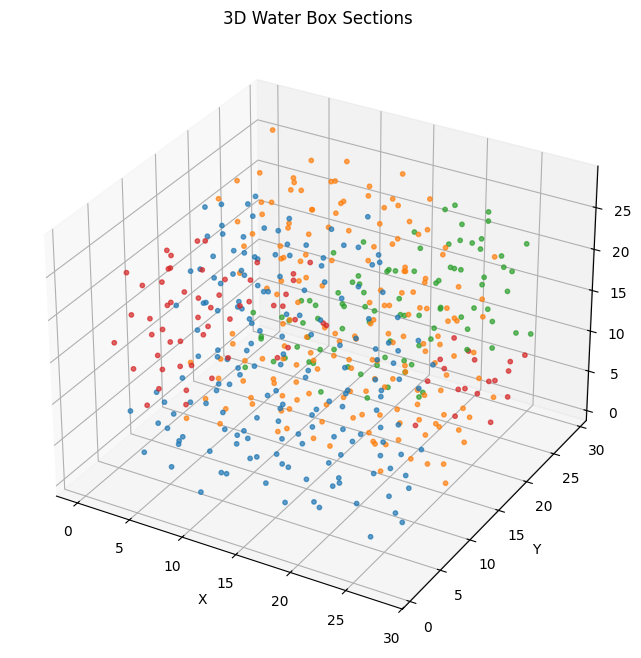

In [353]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap('tab10', partitions)

for i, box in enumerate(boxes):
    if len(box) == 0:
        continue
    ax.scatter(box['x'], box['y'], box['z'], color=colors(i % 10), label=f'Section {i+1}', s=10, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Water Box Sections')
# ax.legend()
plt.show()